# A pure Gurobi-model for the CE-TSP (MIP with SOC constraints)

This notebook provides a simple model for the CE-TSP using Gurobi's branch and cut algorithm, instead our own.
The branch and cut algorithm of Gurobi is extremely efficient, so this is the baseline for our implemention.
If we cannot beat this, there is no use in implementing our own branch and bound algorithm, which is significantly more complex.
However, even with a lot of fine-tuning, the model used here is not able to solve instance with more than ~20 circles efficiently.

The basic idea is to use the original SOCP for a fixed sequence, but instead of fixing the hitting point to the specific circles,
we measure the distances to all circles and enforce that the minimal distance of any circle to any hitting point is at most its radius.
This requires the rather inefficient `MIN` constraint.

In [1]:
import typing

class Circle:
    """
    Instance representation
    """
    def __init__(self, x: float, y: float, radius: float):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, r={self.radius})"

    def __eq__(self, other):
        return self.x == other.x and  self.y == other.y and self.radius == other.radius

    def __hash__(self):
        return hash((self.x, self.y ,self.radius))

# simple plotting  helper
import matplotlib.pyplot as plt
def plot_circle(ax: plt.Axes, circle: Circle, **kwargs):
    patch = plt.Circle((circle.x, circle.y), radius=circle.radius, **kwargs)
    ax.add_patch(patch)

In [2]:
import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB
import math
def compute_tour(circles: typing.List[Circle], path: bool=False) -> typing.List[typing.Tuple[float ,float]]:
    """
    This function efficiently computes the optimal CE-Tour for a given sequence(!) of circles.
    If the order of circles is given, the problem becomes an easy to solve SOC-Program.
    The tour may implicitly cross circles earlier.

    Learn more about SOC: https://www.gurobi.com/events/gurobi-qcp-and-socp-optimizer-overview/
    :param circle_sequence: Sequence of circles (the exact order they are visited)
    :param path: Compute a path instead of a tour.
    :return: Sequence of coordinates of the tour. The coordinates may be slightly off (but not critical).
    """

    min_x = min(c.x for c in circles)
    max_x = max(c.x for c in circles)
    min_y = min(c.y for c in circles)
    max_y = max(c.y for c in circles)
    max_dist = math.sqrt((max_x - min_x)**2 + (max_y - min_y)**2)

    model = gp.Model()
    n = len(circles)

    # tour points
    x = model.addVars(range(n), lb=min_x, ub=max_x, vtype=GRB.CONTINUOUS)
    y = model.addVars(range(n), lb=min_y, ub=max_x, vtype=GRB.CONTINUOUS)

    # length of segments
    f = model.addVars(range(n), lb=0.0, ub=max_dist, vtype=GRB.CONTINUOUS)
    model.setObjective(gp.quicksum(f.values()), sense=GRB.MINIMIZE)

    # x and y-length of segments (difference of segment points)
    w = model.addVars(range(n), lb=min_x-max_x, ub=max_x-min_x, vtype=GRB.CONTINUOUS)
    u = model.addVars(range(n), lb=min_y-max_y, ub=max_y-min_y, vtype=GRB.CONTINUOUS)

    for i in range(n):
        # enforce w,u represent segment lengths (x and y axes)
        model.addConstr(w[i] == x[(i-1)%n] - x[i])
        model.addConstr(u[i] == y[(i-1)%n] - y[i])
        # enforce f represent segment length (euclidean)\
        model.addQConstr(f[i]*f[i] >= w[i]*w[i] + u[i]*u[i])

    # difference of tour points to circle center
    s = {c: model.addVars(range(n), lb=min_x-max_x, ub=max_x-min_x, vtype=GRB.CONTINUOUS) for c in circles}
    t = {c: model.addVars(range(n), lb=min_y-max_y, ub=max_y-min_y, vtype=GRB.CONTINUOUS) for c in circles}

    d = {c: model.addVars(range(n), lb=0.0, ub=max_dist, vtype=GRB.CONTINUOUS) for c in circles}
    min_d = model.addVars(circles, lb=0.0, ub=min(c.radius for c in circles), vtype=GRB.CONTINUOUS)
    for c in circles:
        for i in range(n):
            # enforce d[c][i] to represent distance of tour point i to center of circle c
            model.addQConstr(s[c][i]*s[c][i] + t[c][i]*t[c][i] <= d[c][i]*d[c][i])
            # enforce s,t represent difference to circle center
            model.addConstr(s[c][i] == c.x - x[i])
            model.addConstr(t[c][i] == c.y - y[i])
        # enforce min_d[c] to represent minimum distance of tour to circle c
        # Remark: Usually it is more efficient, to model this yourself with manually tuned big-M constraints
        if c != circles[0]:
            model.addGenConstrMin(min_d[c], d[c].values(), max_dist)
        # enforce min_d[c] to be smaller than radius of circle c
        model.addConstr(min_d[c] == c.radius)
    
    # Fix the first point to the first circle
    model.addConstr(d[circles[0]][0] == circles[0].radius)

    # 1% gap is fine
    model.Params.MIPGap = 0.01

    # max 120 seconds
    model.Params.TimeLimit = 120

    model.optimize()
    return [(x[i].X, y[i].X) for i in range(n)]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 561 rows, 864 columns and 1137 nonzeros
Model fingerprint: 0x49cc8703
Model has 272 quadratic constraints
Model has 15 general constraints
Variable types: 864 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 6e+00]
  GenCon const rng [8e+00, 8e+00]
Presolve added 75 rows and 32 columns
Presolve time: 0.01s
Presolved: 636 rows, 896 columns, 1501 nonzeros
Presolved model has 244 quadratic constraint(s)
Variable types: 669 co

     0     0    0.00000    0    8          -    0.00000      -     -    0s
     0     0    0.00000    0   26          -    0.00000      -     -    0s
     0     0    0.00000    0   20          -    0.00000      -     -    0s
     0     0    0.00000    0   29          -    0.00000      -     -    0s
     0     0    0.00000    0   19          -    0.00000      -     -    0s
     0     0    0.00000    0   28          -    0.00000      -     -    0s
     0     0    0.00000    0   44          -    0.00000      -     -    0s
     0     0    0.00000    0   47          -    0.00000      -     -    0s
     0     0    0.00000    0   47          -    0.00000      -     -    0s
     0     0    0.00000    0   45          -    0.00000      -     -    0s
     0     0    0.00000    0   45          -    0.00000      -     -    0s
     0     0    0.00000    0   45          -    0.00000      -     -    0s
     0     0    0.00000    0   44          -    0.00000      -     -    0s
     0     0    0.00000  

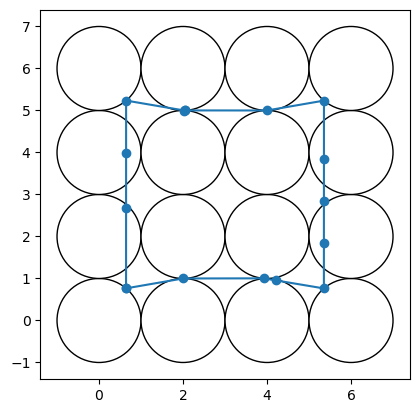

In [3]:
fig = plt.Figure(figsize=(10,10))
ax = plt.gca()
circles = [Circle(0,0, 1), Circle(3,0, 1), Circle(5, 2, 1), Circle(3,3, 1), Circle(0, 4, 1)]

circles = [
    Circle(2*x, 2*y, 1) for x in range(4) for y in range(4)
]


tour = compute_tour(circles)
for c in circles:
    plot_circle(ax, c, facecolor="white", zorder=1, ec="black")
plt.plot([p[0] for p in tour]+[tour[0][0]], [p[1] for p in tour]+[tour[0][1]], 'o-')
ax.set_aspect('equal', 'box')
plt.show()

In [6]:
# Comparison to our implementation
from cetsp_bnb2 import (
    Circle as Circle_,
    Instance,
    compute_tour_by_2opt,
    branch_and_bound,
    Point,
)
instance = Instance(
    [
        Circle_(Point(float(c.x), float(c.y)), float(c.radius))
        for c in circles
    ]
)
initial_solution = compute_tour_by_2opt(instance)
ub, lb, stats = branch_and_bound(
        instance, (lambda context: None), initial_solution, 120
    )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Using node simplification.
Exploring on 8 threads
Branching on farthest circle.
Using GlobalConvexHullRule
Using DfsBfs search
py_callback 0x7ffd7ab61970
Starting with root node of size 4
i	LB	|	UB	|	Time
1	18.3804	|	19.7678	|	0.003s
2	18.3804	|	19.7678	|	0.004s
3	18.3804	|	19.7678	|	0.005s
4	18.3804	|	19.7678	|	0.009s
5	18.3804	|	18.4423	|	0.01s
---------------
5	18.3804	|	18.4423
5 iterations with 5 nodes explored and 4 branches.
